<a href="https://colab.research.google.com/github/MertBiyikli/DataMiningAssignments/blob/main/RL_Tutorial_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Clustering Tutorial

In this notebook we apply several deep clustering algorithm to the German Traffic Sign Recognition Data Set and compare their performance.

We use the clustpy package for running the algorithms: https://github.com/collinleiber/ClustPy

In [1]:
# Install needed packages
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 693.6 kB/s eta 0:00:00


In [2]:
# Download the tutorial folder
!gdown 1NtPjGv2X9_cfGo5TwohEtAX3pZbVmX-Z

Downloading...
From (original): https://drive.google.com/uc?id=1NtPjGv2X9_cfGo5TwohEtAX3pZbVmX-Z
From (redirected): https://drive.google.com/uc?id=1NtPjGv2X9_cfGo5TwohEtAX3pZbVmX-Z&confirm=t&uuid=1ce63564-35e1-4991-ab6e-ab05cf7a1c70
To: /content/tutorial.zip
100% 308M/308M [00:05<00:00, 53.0MB/s]


In [3]:
!unzip tutorial.zip

Archive:  tutorial.zip
   creating: tutorial/
   creating: tutorial/.circleci/
  inflating: tutorial/.circleci/config.yml  
   creating: tutorial/.git/
   creating: tutorial/.git/branches/
  inflating: tutorial/.git/config    
  inflating: tutorial/.git/description  
  inflating: tutorial/.git/HEAD      
   creating: tutorial/.git/hooks/
  inflating: tutorial/.git/hooks/applypatch-msg.sample  
  inflating: tutorial/.git/hooks/commit-msg.sample  
  inflating: tutorial/.git/hooks/fsmonitor-watchman.sample  
  inflating: tutorial/.git/hooks/post-update.sample  
  inflating: tutorial/.git/hooks/pre-applypatch.sample  
  inflating: tutorial/.git/hooks/pre-commit.sample  
  inflating: tutorial/.git/hooks/pre-merge-commit.sample  
  inflating: tutorial/.git/hooks/pre-push.sample  
  inflating: tutorial/.git/hooks/pre-rebase.sample  
  inflating: tutorial/.git/hooks/pre-receive.sample  
  inflating: tutorial/.git/hooks/prepare-commit-msg.sample  
  inflating: tutorial/.git/hooks/push-to-checko

In [4]:
# install clustpy
%cd /content/tutorial/
!python setup.py install --prefix ~/.local
!python setup.py build_ext --inplace

/content/tutorial
/usr/local/lib/python3.10/dist-packages/setuptools/dist.py:294: InformationOnly: Normalizing '0.0.2-alpha' to '0.0.2a0'
  self.metadata.version = self._normalize_version(self.metadata.version)
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ****************************************

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
import os
import sys
# make our own package visible by appending the path to the parent dir
src_dir = os.path.abspath(os.path.join(os.getcwd(), "content", "tutorial"))
sys.path.append(src_dir)

In [7]:
# Importing all necessary libraries

%load_ext autoreload
%autoreload 2

# internal packages
from collections import Counter
# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from clustpy.metrics import unsupervised_clustering_accuracy
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
import pandas as pd
import clustpy
from clustpy.deep import encode_batchwise, get_dataloader
import joblib
import logging

# specify base paths

data_path = "/"
base_path = "models"


print("Versions")
print("torch: ",torch.__version__)
print("torchvision: ",torchvision.__version__)
print("numpy: ", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("pandas:", pd.__version__)
print("clustpy:", clustpy.__version__)

Versions
torch:  2.5.0+cu121
torchvision:  0.20.0+cu121
numpy:  1.26.4
scikit-learn: 1.5.2
pandas: 2.2.2
clustpy: 0.0.2-alpha


In [8]:
# make execution deterministic
from clustpy.deep._utils import set_torch_seed

set_torch_seed(np.random.RandomState(2023))

In [9]:
# Some helper functions, you can ignore those in the beginning
def denormalize_fn(tensor:torch.Tensor, mean, std, shape=None, **kwargs)->torch.Tensor:

    """
    This applies an inverse z-transformation and reshaping to visualize the images properly.
    """
    if shape is None:
        shape = tensor.shape
    if len(shape) == 3:
        n_channels, width, height = shape
    else:
        _, n_channels, width, height = shape

    pt_std = torch.as_tensor(std, dtype=torch.float32, device=tensor.device)
    pt_mean = torch.as_tensor(mean, dtype=torch.float32, device=tensor.device)
    unnormalize_fn = torchvision.transforms.Normalize((-pt_mean / pt_std).tolist(), (1.0 / pt_std).tolist())
    tensor_view = tensor.view(-1, n_channels, width, height)
    # tensor_view = unnormalize_fn(tensor_view)
    tensor_view = torch.stack([unnormalize_fn(tensor_view[i]) for i in range(tensor_view.shape[0])])

    return (tensor_view * 255).int().detach()

def plot_images(images:torch.Tensor, pad:int=1, nrow=8):
    """Aligns multiple images on an N by nrow grid"""
    def imshow(img):
        plt.figure(figsize=(10, 20))
        npimg = img.numpy()
        npimg = np.array(npimg)
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1, 2, 0)),
                   vmin=0, vmax=1)

    # code to avoid "Clipping ..." message, see https://stackoverflow.com/questions/54848310/disable-matplotlib-warning-when-using-pyplot-imshow
    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)

    imshow(torchvision.utils.make_grid(images, pad_value=255, normalize=False, padding=pad, nrow=nrow))
    logger.setLevel(old_level)

    plt.show();

def detect_device():
    """Automatically detects if you have a cuda enabled GPU"""
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

def get_label_subset(data, labels, label_subset):
    """Returns subset of selected labels"""
    labels_new = []
    data_new = []
    for label_i in label_subset:
        mask_i = labels == label_i
        labels_new.append(labels[mask_i].copy())
        data_new.append(data[mask_i].copy())
    data_new = np.concatenate(data_new)
    labels_new = np.concatenate(labels_new)
    return data_new, labels_new

In [10]:
# some analysis functions
from scipy.optimize import linear_sum_assignment
from confusion_matrix import ConfusionMatrix
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_mutual_info_score
from umap import UMAP
from collections import OrderedDict

def get_colors_dict():
    # Get colors dict and remove white colors
    colors_dict = OrderedDict(mcolors.CSS4_COLORS)
    for name, _ in mcolors.CSS4_COLORS.items():
        if "white" in name.lower() or "light" in name.lower() or "snow" in name.lower() or "seashell" in name.lower()  or "grey" in name.lower():
            del colors_dict[name]
    return colors_dict

def dimred_plots(data, labels, clustering):
    """Creates a PCA and UMAP plot"""
    matched_clustering = match_labels(labels, clustering)

    fig, axes = plt.subplots(ncols=4, figsize=(16,4))
    setting = {0:["Ground Truth", labels], 1:["Clustering", matched_clustering],
               2:["Ground Truth", labels], 3:["Clustering", matched_clustering]}
    for idx, ax in enumerate(axes):
        if idx == 0:
            reducer = PCA()
            reduced = reducer.fit_transform(data)
            method = "PCA"
        elif idx == 2:
            reducer = UMAP()
            reduced = reducer.fit_transform(data, )
            method = "UMAP"
        colors_dict = get_colors_dict()
        title, used_labels = setting[idx]
        unique_labels = list(set(used_labels.tolist()))
        unique_labels.sort()
        for u_i in unique_labels:
            color = colors_dict.popitem()[1]
            name_i = f"{u_i}-{signnames[u_i]}"
            ax.scatter(reduced[used_labels==u_i,0], reduced[used_labels==u_i,1], c=color, s=1, label=name_i, alpha=0.7)

        ax.set_title(method + " - " + title)
        ax.set(yticklabels=[], xticklabels=[])  # remove the tick labels
        ax.tick_params(left=False, bottom=False)  # remove the ticks
        if idx == 0:
            ax.legend(loc='upper center', bbox_to_anchor=(2.2, -0.1), fancybox=False, shadow=False, ncol=4, markerscale=10, fontsize=14, handletextpad=0.01, columnspacing=0.1)
    plt.show();


def plot_confusion_matrix(labels, clustering, label_names=None, title=None):
    """Plots a confusion matrix for a given ground truth and clustering"""
    cm = ConfusionMatrix(labels, clustering)
    cm.rearrange()
    cm.plot(labels_true_name=label_names, figsize=(5,5), fontsize=12, title=title)

def evaluate_clustering(labels, clustering):
    """Calculates ACC, ARI and NMI for a given ground truth and clustering"""


     # Check and adjust the shape of clustering if necessary
    if clustering.shape[0] != labels.shape[0]:
        print("WARNING: Number of samples in 'clustering' and 'labels' are different.")
        print("Adjusting 'clustering' to match the size of 'labels'.")
        clustering = clustering[:labels.shape[0]]  # Take only the first n elements

    clustering = np.array(clustering).flatten().astype(int)
    acc = unsupervised_clustering_accuracy(labels, clustering) * 100
    ari = adjusted_rand_score(labels, clustering) * 100
    nmi = normalized_mutual_info_score(labels, clustering) * 100
    ami = adjusted_mutual_info_score(labels, clustering) * 100
    print(f"ACC: {acc:.2f}, ARI: {ari:.2f}, NMI: {nmi:.2f}, AMI: {ami:.2f}")

def plot_reconstructed_centers(centers, model, device):
    """Reconstructs and plots centers"""
    rec_centers = model.decode(torch.from_numpy(centers).float().to(device)).detach().cpu()
    plot_images(denormalize(rec_centers), nrow=rec_centers.shape[0])

def match_labels(labels1, labels2):
    """Maps labels2 to labels1 and returns matched labels2"""
    if len(set(labels2.tolist())) == len(set(labels1.tolist())):
        D = max(labels2.max(), labels1.max()) + 1
        w = np.zeros((D, D), dtype=np.int64)
        for j in range(labels2.size):
            w[labels2[j], labels1[j]] += 1
        # apply hungarian method to match colors
        ind = linear_sum_assignment(w.max() - w)
        ind = np.array(ind).transpose()
        ind_d = {i:j for i,j in ind}
        matched_labels = labels2.copy()
        for j in range(labels2.shape[0]):
            matched_labels[j] = ind_d[labels2[j]]
    return matched_labels

def calculate_centers_from_labels(X, y):
    """Calculates mean center per unique labeling"""
    unique_labels = list(set(y.tolist()))
    unique_labels.sort()
    centers = []
    for u_i in unique_labels:
        center_i = X[y==u_i].mean(0, keepdims=True)
        centers.append(center_i)
    centers = np.concatenate(centers)
    return centers


def plot_matched_reconstructed_centers(labels, clustering, embedding, model, device):
    """Plot Reconstructed centers where clustering is matched with ground truth labeling"""
    matched_clustering = match_labels(labels, clustering)
    cluster_centers = calculate_centers_from_labels(embedding, matched_clustering)
    label_centers = calculate_centers_from_labels(embedding, labels)
    real_centers = calculate_centers_from_labels(data, labels)
    print("Ground Truth Centers - Image Space")
    plot_images(denormalize(torch.from_numpy(real_centers)), nrow=10)
    print("Ground Truth Centers - Autoencoder")
    plot_reconstructed_centers(label_centers, model, device)
    print("Cluster Centers")
    plot_reconstructed_centers(cluster_centers, model, device)

# German Traffic Sign Recognition Benchmark (GTSRB) Data Set


# Load and Preprocess Data Set


100%|██████████| 187M/187M [00:06<00:00, 27.3MB/s]


Extracting /gtsrb/GTSRB-Training_fixed.zip to /gtsrb


100%|██████████| 89.0M/89.0M [00:03<00:00, 22.6MB/s]


Extracting /gtsrb/GTSRB_Final_Test_Images.zip to /gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 300kB/s]


Extracting /gtsrb/GTSRB_Final_Test_GT.zip to /gtsrb
Plot data before preprocessing


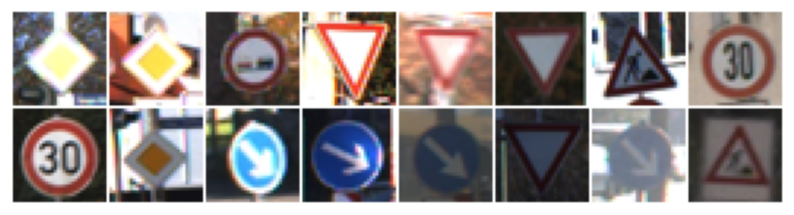

Plot data after preprocessing with Histogram Equalization


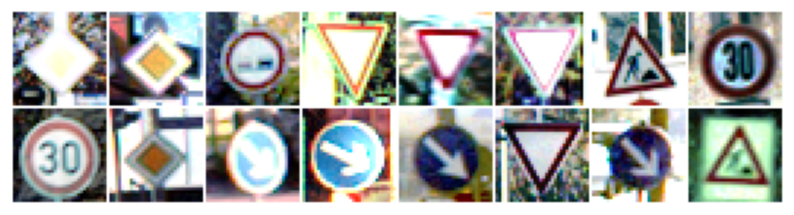

########################################
Data Set Statistics
########################################
Number of instances: 11520
Number of dimensions: 3072
Mean before norm. [0.556, 0.552, 0.553] and after [-0.00, -0.00, -0.00]
Std before norm.  [0.323, 0.323, 0.323] and after [1.00, 1.00, 1.00]

Number of clusters:  6
Size 1-Speed limit (30km/h): 2220
Size 9-No passing: 1470
Size 12-Priority road: 2100
Size 13-Yield: 2160
Size 25-Road work: 1500
Size 38-Keep right: 2070
########################################


In [11]:
from clustpy.data import load_gtsrb

# specify which classes to use
label_subset = [1, 9, 12, 13, 25, 38]


# load signnames for interpretation
df = pd.read_csv(os.path.join("signnames.csv"))
signnames = df.to_dict()["SignName"]
label_names = [f"{i}-{signnames[i]}" for i in label_subset]

# load data set
data, labels = load_gtsrb(flatten=False, downloads_path=data_path)
# Select subset of labels from data
data, labels = get_label_subset(data, labels, label_subset)
# convert data from numpy array to torch tensor
data = torch.from_numpy(data)

print("Plot data before preprocessing")
rnd_indices = np.random.randint(0, data.shape[0], 16).tolist()
plot_images(data[rnd_indices].int())

# apply histogram equalization
data = torchvision.transforms.functional.equalize(data.to(torch.uint8))

print("Plot data after preprocessing with Histogram Equalization")
plot_images(data[rnd_indices])

# convert data to torch.tensor float
data = data.float()
# scale data from 0-255 to 0 - 1
data /= 255.0


# calculate mean and standard deviation for the 3 RGB channels
mean = data.mean([0, 2, 3])
std = data.std([0, 2, 3])
# normalize channels
data -= mean.reshape(1, 3, 1, 1)
data /= std.reshape(1, 3, 1, 1)
# specify denormalization function for plotting
denormalize = lambda x: denormalize_fn(x, mean=mean, std=std, shape=(3, 32, 32))
# calculate new statistics for reference
_new_mean = data.mean([0, 2, 3])
_new_std = data.std([0, 2, 3])

#flatten data and conver to to numpy
data = data.reshape(-1, data.shape[1]*data.shape[2]*data.shape[3])

print("#"*40)
print("Data Set Statistics")
print("#"*40)
print(f"Number of instances: {data.shape[0]}")
print(f"Number of dimensions: {data.shape[1]}")
print(f"Mean before norm. [{mean[0]:.3f}, {mean[1]:.3f}, {mean[2]:.3f}] and after [{_new_mean[0]:.2f}, {_new_mean[1]:.2f}, {_new_mean[2]:.2f}]")
print(f"Std before norm.  [{std[0]:.3f}, {std[1]:.3f}, {std[2]:.3f}] and after [{_new_std[0]:.2f}, {_new_std[1]:.2f}, {_new_std[2]:.2f}]")
counter = Counter(labels.tolist())
print()
n_clusters = len(counter)
print("Number of clusters: ", n_clusters)
for label_i in label_subset:
    print(f"Size {label_i}-{signnames[label_i]}: {counter[label_i]}")
print("#"*40)

# Pretrain Autoencoder

In [12]:
from clustpy.deep.autoencoders import FeedforwardAutoencoder

# specify device on which experiments should be run on
device = detect_device()
# Specify Autoencoder (AE) for encoder and decoder
ae = FeedforwardAutoencoder(layers=[3072, 500, 500, 2000, 10]).to(device)

In [13]:
# dataloader for training
train_dl = get_dataloader(data, batch_size=256, shuffle=True)
# dataloader for evaluation
dl = get_dataloader(data, 512, shuffle=False)


In [14]:
TRAIN = False
# Setup
model_name = "pretrained_ae.pt"
model_path = os.path.join(base_path, model_name)

weight_decay = 1e-2
ae_lr = 1e-3
if TRAIN:
    n_epochs = 250
    scheduler = torch.optim.lr_scheduler.StepLR
    scheduler_params = {"step_size": 50, "gamma": 0.5}
    ae.fit(n_epochs=n_epochs, optimizer_params={"lr":ae_lr}, dataloader=train_dl, device=device, print_step=10, model_path=model_path,
           scheduler=scheduler, scheduler_params=scheduler_params,
           optimizer_class=lambda params, lr: torch.optim.AdamW(params, lr, weight_decay=weight_decay))
    ae.eval();
else:
    sd = torch.load(model_path, map_location="cpu")
    ae.load_state_dict(sd)
    ae.fitted = True
    ae.eval()
    ae.to(device)

<ipython-input-14-0d01f4a53507>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(model_path, map_location="cpu")


## Plot reconstructed images

In [15]:
from clustpy.deep import encode_decode_batchwise

# Embed and Reconstruct data in a mini-batch manner
emb, rec = encode_decode_batchwise(dl, ae, device)

Original Images


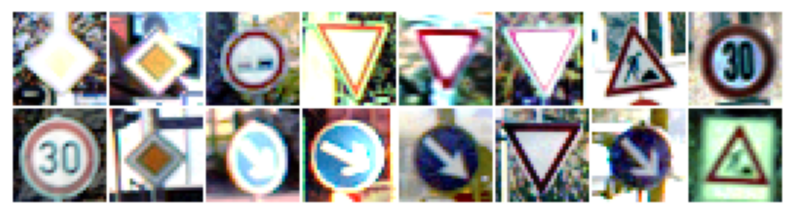

Reconstructed Images


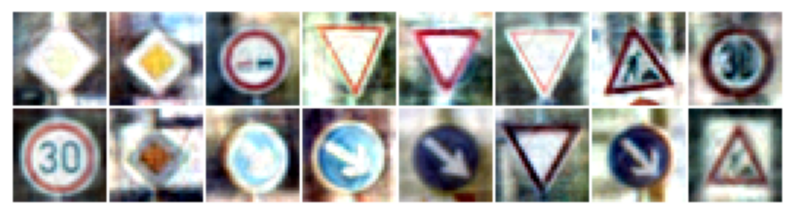

In [16]:
print("Original Images")
plot_images(denormalize(data[rnd_indices]))
print("Reconstructed Images")
plot_images(denormalize(torch.from_numpy(rec[rnd_indices])))

# Apply Clustering with KMeans

In [17]:
from sklearn.cluster import KMeans

kmeans_images = KMeans(n_clusters, n_init=10)
kmeans_images.fit(data)

kmeans = KMeans(n_clusters, n_init=10)
kmeans.fit(emb)

print("KMeans-Images - Clustering Result")
evaluate_clustering(labels, kmeans_images.labels_)
print("\nKMeans - Clustering Result")
evaluate_clustering(labels, kmeans.labels_)

KMeans-Images - Clustering Result
ACC: 32.69, ARI: 10.62, NMI: 15.58, AMI: 15.52

KMeans - Clustering Result
ACC: 71.69, ARI: 51.62, NMI: 59.13, AMI: 59.10


Ground Truth Centers - Image Space


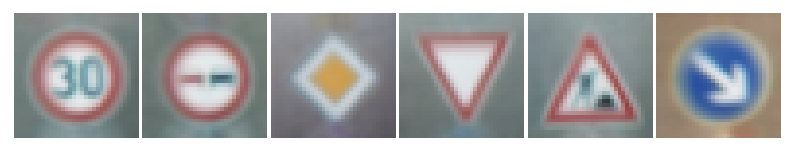

Ground Truth Centers - Autoencoder


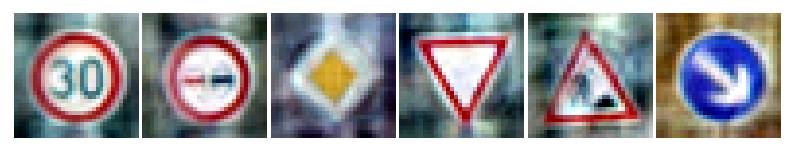

Cluster Centers


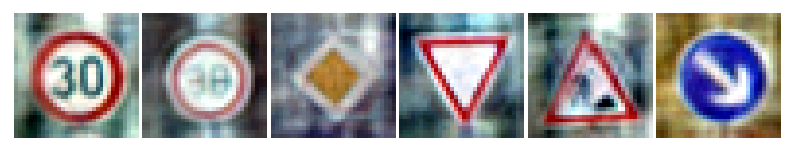

In [18]:
plot_matched_reconstructed_centers(labels, kmeans.labels_, emb, ae, device)

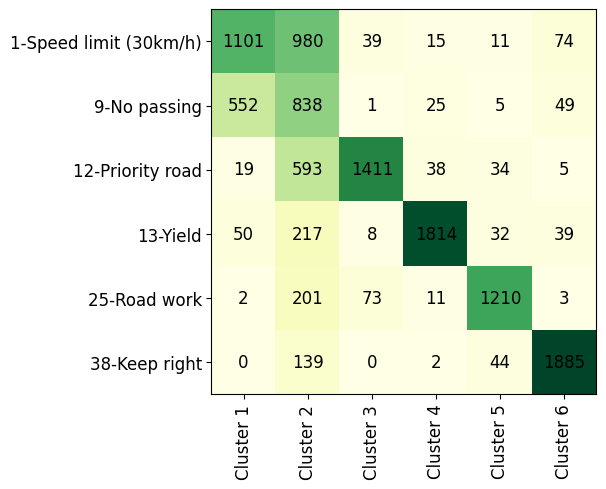

In [19]:
plot_confusion_matrix(labels, kmeans.labels_, label_names=label_names)

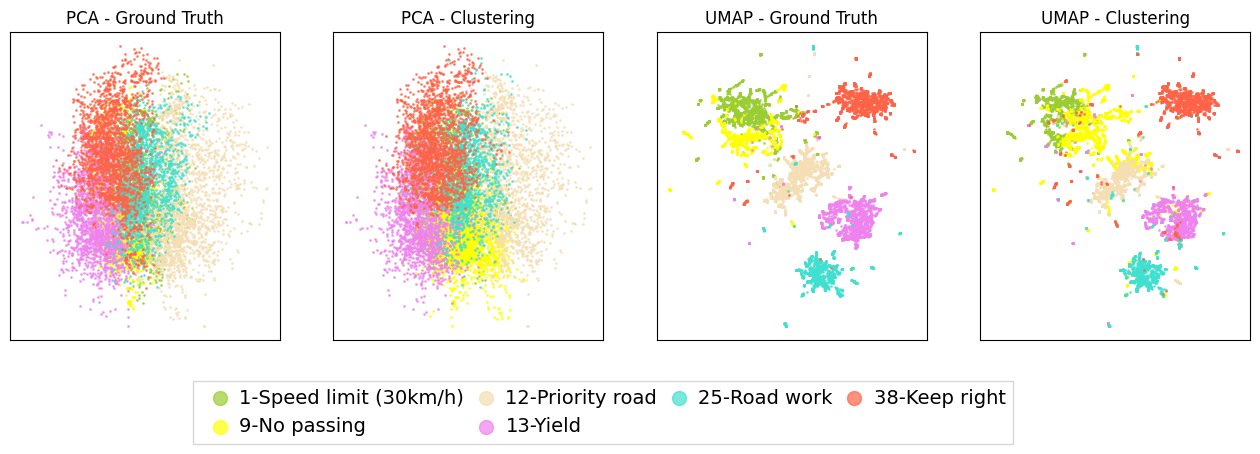

In [20]:
dimred_plots(emb, labels, kmeans.labels_)

# Apply Clustering with DCN

In [21]:
from clustpy.deep import DCN

dcn_name = "dcn.pt"

TRAIN = True

clustering_lr = 1e-4
if TRAIN:
    # load pretrained autoencoder
    sd = torch.load(model_path)
    ae.load_state_dict(sd)
    ae.to(device)
    ae.eval();

    dcn = DCN(n_clusters=n_clusters,
              clustering_epochs=150,
              autoencoder=ae,
              clustering_optimizer_params={"lr": clustering_lr},
             )
    dcn.fit(data)

    # save with joblib
    joblib.dump(dcn, os.path.join(base_path, dcn_name))
else:
    # load with joblib
    dcn = joblib.load(os.path.join(base_path, dcn_name))
    dcn.autoencoder.to(device)

print("KMeans - Clustering Result")
evaluate_clustering(labels, kmeans.labels_)
print("\nDCN - Clustering Result")
evaluate_clustering(labels, dcn.labels_)

<ipython-input-21-ca5e422f86d3>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(model_path)


KMeans - Clustering Result
ACC: 71.69, ARI: 51.62, NMI: 59.13, AMI: 59.10

DCN - Clustering Result
ACC: 73.43, ARI: 63.07, NMI: 69.39, AMI: 69.37


In [22]:
# Embed and Reconstruct data in a mini-batch manner
emb, rec = encode_decode_batchwise(dl, dcn.autoencoder, device)

Original Images


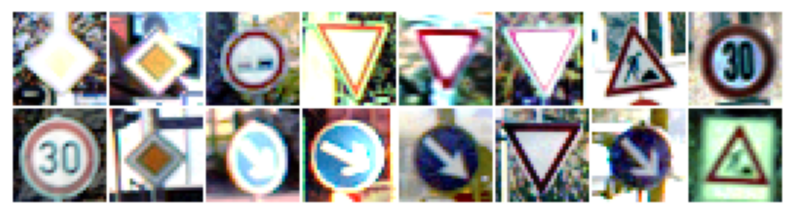

Reconstructed Images


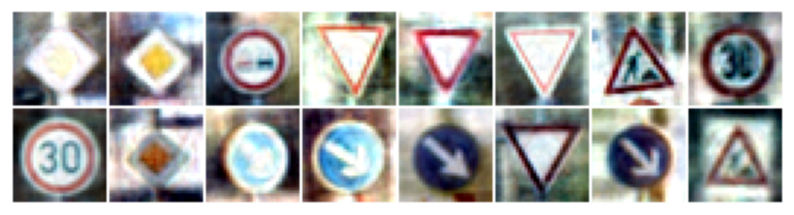

In [23]:
print("Original Images")
plot_images(denormalize(data[rnd_indices]))
print("Reconstructed Images")
plot_images(denormalize(torch.from_numpy(rec[rnd_indices])))

Ground Truth Centers - Image Space


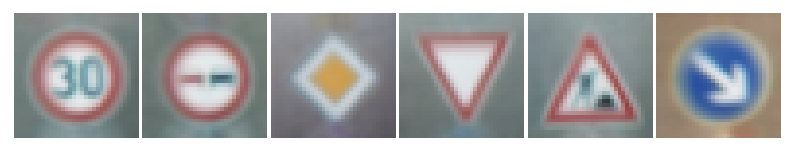

Ground Truth Centers - Autoencoder


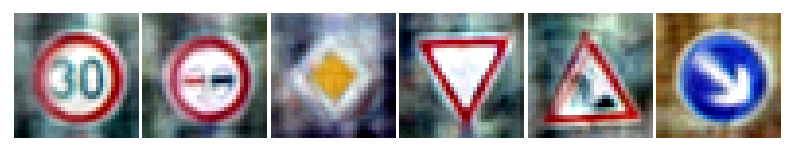

Cluster Centers


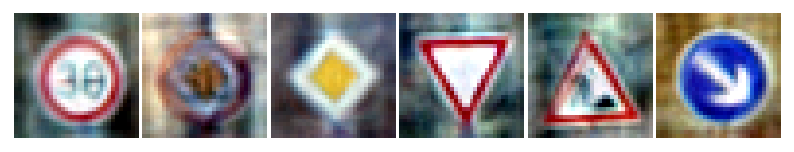

In [24]:
plot_matched_reconstructed_centers(labels, dcn.labels_, emb, dcn.autoencoder, device)

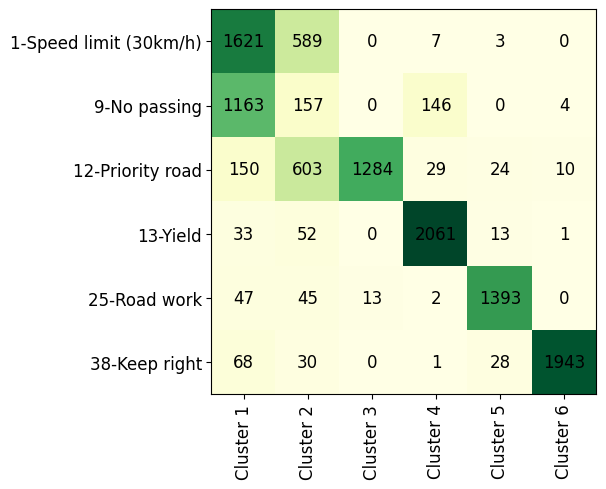

In [25]:
plot_confusion_matrix(labels, dcn.labels_, label_names=label_names)

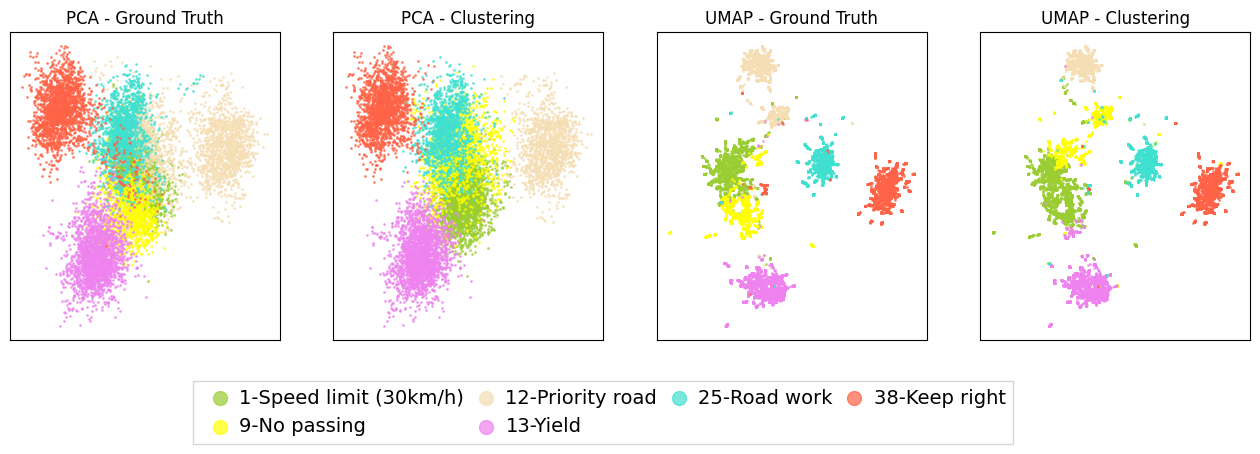

In [26]:
dimred_plots(emb, labels, dcn.labels_)

# Apply Clustering with DEC

In [27]:
from clustpy.deep import DEC

dec_name = "dec.pt"

TRAIN = True

clustering_lr = 1e-4
if TRAIN:
    # load pretrained autoencoder
    sd = torch.load(model_path)
    ae.load_state_dict(sd)
    ae.to(device)
    ae.eval();

    dec = DEC(n_clusters=n_clusters,
              clustering_epochs=150,
              autoencoder=ae,
              clustering_optimizer_params={"lr": clustering_lr},
             )
    dec.fit(data)

    # save with joblib
    joblib.dump(dec, os.path.join(base_path, dec_name))
else:
    # load with joblib
    dec = joblib.load(os.path.join(base_path, dec_name))
    dec.autoencoder.to(device)
print("KMeans - Clustering Result")
evaluate_clustering(labels, kmeans.labels_)
print("\nDCN - Clustering Result")
evaluate_clustering(labels, dcn.labels_)
print("\nDEC - Clustering Result")
evaluate_clustering(labels, dec.labels_)

<ipython-input-27-27584dd707ee>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(model_path)


KMeans - Clustering Result
ACC: 71.69, ARI: 51.62, NMI: 59.13, AMI: 59.10

DCN - Clustering Result
ACC: 73.43, ARI: 63.07, NMI: 69.39, AMI: 69.37

DEC - Clustering Result
ACC: 69.36, ARI: 59.96, NMI: 68.17, AMI: 68.15


In [28]:
# Embed and Reconstruct data in a mini-batch manner
emb, rec = encode_decode_batchwise(dl, dec.autoencoder, device)

Original Images


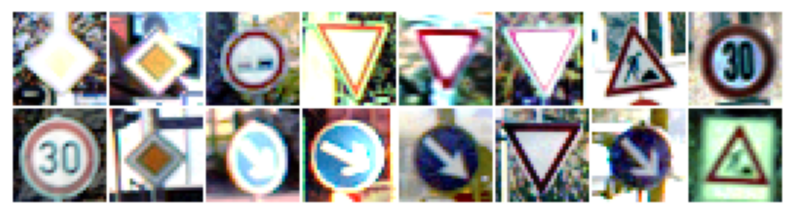

Reconstructed Images


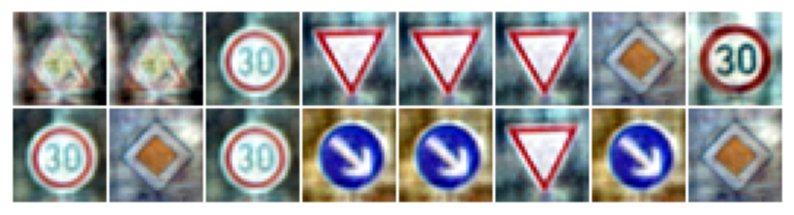

In [29]:
print("Original Images")
plot_images(denormalize(data[rnd_indices]))
print("Reconstructed Images")
plot_images(denormalize(torch.from_numpy(rec[rnd_indices])))

Ground Truth Centers - Image Space


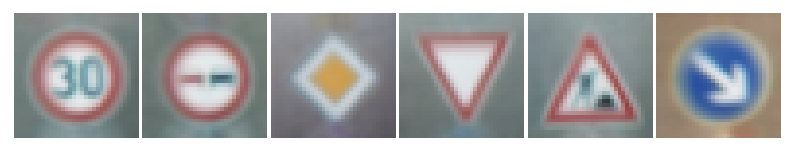

Ground Truth Centers - Autoencoder


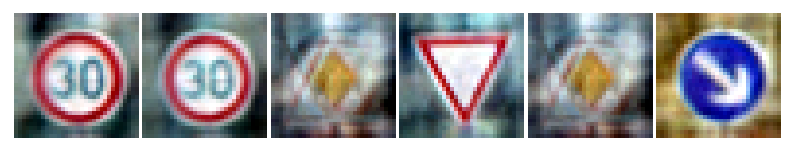

Cluster Centers


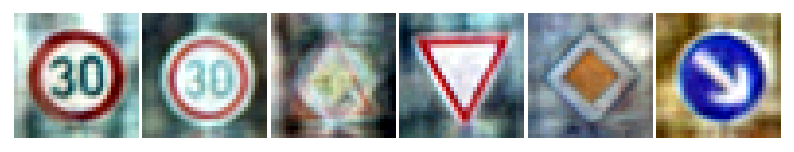

In [30]:
plot_matched_reconstructed_centers(labels, dec.labels_, emb, dec.autoencoder, device)

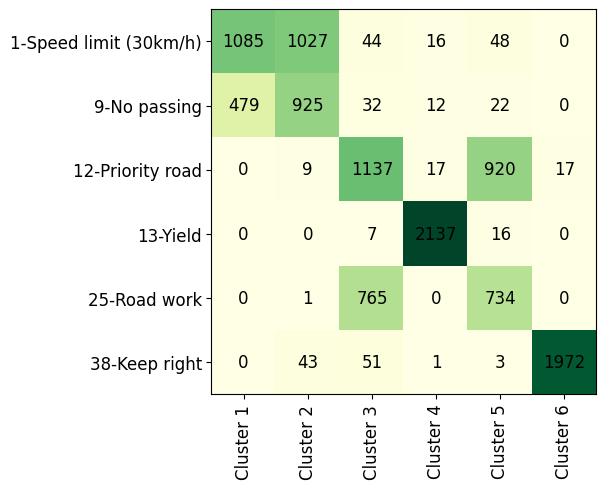

In [31]:
plot_confusion_matrix(labels, dec.labels_, label_names=label_names)

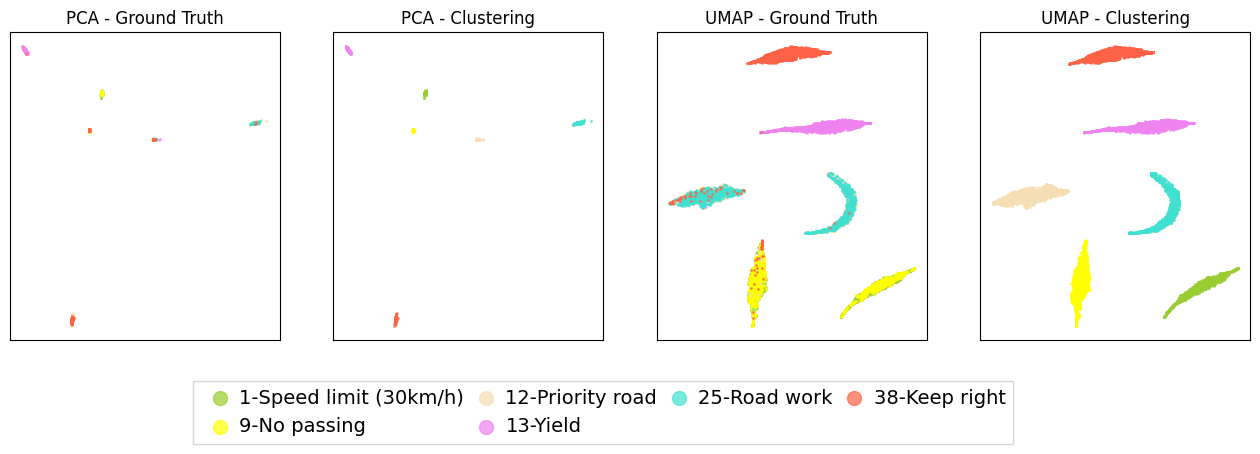

In [32]:
dimred_plots(emb, labels, dec.labels_)

# Apply Clustering with IDEC

In [33]:
from clustpy.deep import IDEC

idec_name = "idec.pt"

TRAIN = True

clustering_lr = 1e-4
if TRAIN:
    # load pretrained autoencoder
    sd = torch.load(model_path)
    ae.load_state_dict(sd)
    ae.to(device)
    ae.eval();

    idec = IDEC(n_clusters=n_clusters,
                clustering_epochs=150,
                autoencoder=ae,
                clustering_optimizer_params={"lr": clustering_lr},
             )
    idec.fit(data)

    # save with joblib
    joblib.dump(idec, os.path.join(base_path, idec_name))
else:
    # load with joblib
    idec = joblib.load(os.path.join(base_path, idec_name))
    idec.autoencoder.to(device)

print("KMeans - Clustering Result")
evaluate_clustering(labels, kmeans.labels_)
print("\nDCN - Clustering Result")
evaluate_clustering(labels, dcn.labels_)
print("\nDEC - Clustering Result")
evaluate_clustering(labels, dec.labels_)
print("\nIDEC - Clustering Result")
evaluate_clustering(labels, idec.labels_)

<ipython-input-33-045b9b432550>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(model_path)


KMeans - Clustering Result
ACC: 71.69, ARI: 51.62, NMI: 59.13, AMI: 59.10

DCN - Clustering Result
ACC: 73.43, ARI: 63.07, NMI: 69.39, AMI: 69.37

DEC - Clustering Result
ACC: 69.36, ARI: 59.96, NMI: 68.17, AMI: 68.15

IDEC - Clustering Result
ACC: 78.70, ARI: 66.47, NMI: 70.68, AMI: 70.67


In [34]:
# Embed and Reconstruct data in a mini-batch manner
emb, rec = encode_decode_batchwise(dl, idec.autoencoder, device)

Original Images


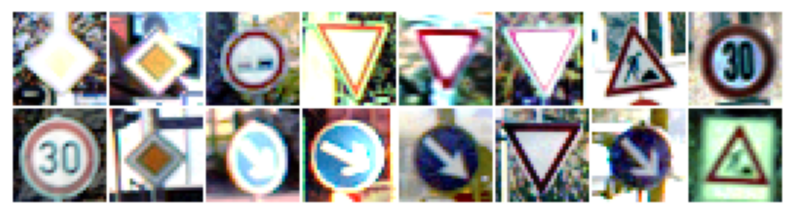

Reconstructed Images


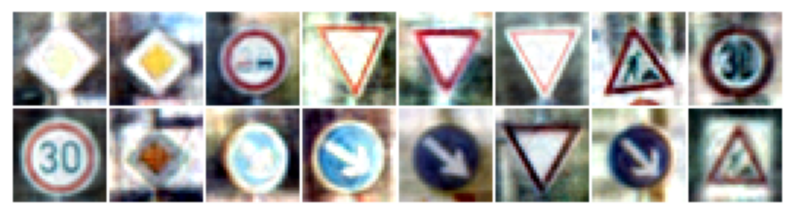

In [35]:
print("Original Images")
plot_images(denormalize(data[rnd_indices]))
print("Reconstructed Images")
plot_images(denormalize(torch.from_numpy(rec[rnd_indices])))

Ground Truth Centers - Image Space


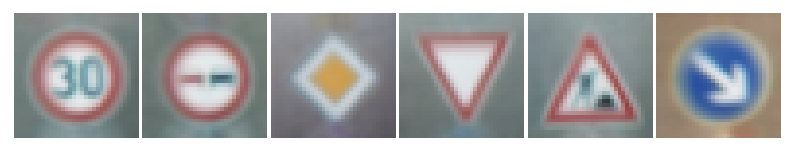

Ground Truth Centers - Autoencoder


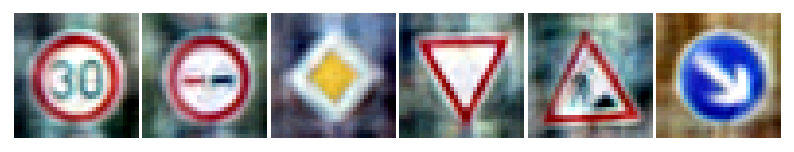

Cluster Centers


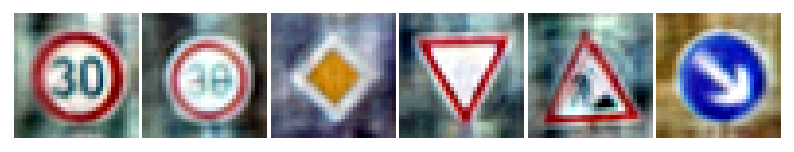

In [36]:
plot_matched_reconstructed_centers(labels, idec.labels_, emb, idec.autoencoder, device)

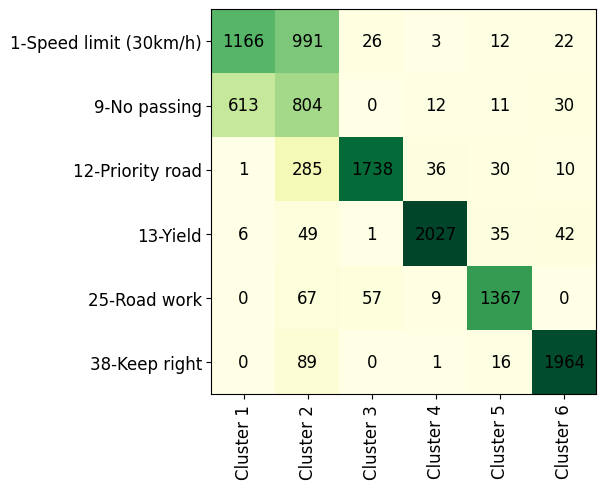

In [37]:
plot_confusion_matrix(labels, idec.labels_, label_names=label_names)

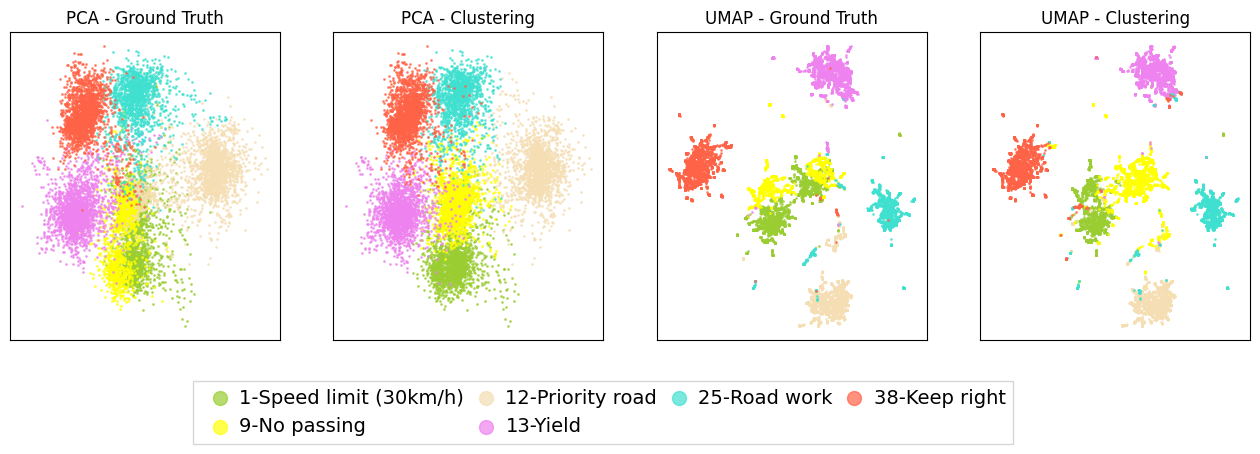

In [38]:
dimred_plots(emb, labels, idec.labels_)

# Apply Custering ACeDeC Exercsie 2-1 c)

In [39]:
from clustpy.deep import ACeDeC

acedec_name = "enrc.pt"

TRAIN = True

clustering_lr = 1e-4
if TRAIN:
    # load pretrained autoencoder
    sd = torch.load(model_path)
    ae.load_state_dict(sd)
    ae.to(device)
    ae.eval();

    acedec = ACeDeC(n_clusters=n_clusters,
                clustering_epochs=150,
                autoencoder=ae,
                clustering_optimizer_params={"lr": clustering_lr},
             )
    acedec.fit(data)

    # save with joblib
    joblib.dump(acedec, os.path.join(base_path, acedec_name))
else:
    # load with joblib
    acedec = joblib.load(os.path.join(base_path, acedec_name))
    acedec.autoencoder.to(device)



print("KMeans - Clustering Result")
evaluate_clustering(labels, kmeans.labels_)
print("\nDCN - Clustering Result")
evaluate_clustering(labels, dcn.labels_)
print("\nDEC - Clustering Result")
evaluate_clustering(labels, dec.labels_)
print("\nIDEC - Clustering Result")
evaluate_clustering(labels, idec.labels_)
print("\nACeDeC - Clustering Result")
evaluate_clustering(labels, acedec.labels_)

<ipython-input-39-0cde8a8a4727>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(model_path)


KMeans - Clustering Result
ACC: 71.69, ARI: 51.62, NMI: 59.13, AMI: 59.10

DCN - Clustering Result
ACC: 73.43, ARI: 63.07, NMI: 69.39, AMI: 69.37

DEC - Clustering Result
ACC: 69.36, ARI: 59.96, NMI: 68.17, AMI: 68.15

IDEC - Clustering Result
ACC: 78.70, ARI: 66.47, NMI: 70.68, AMI: 70.67

ACeDeC - Clustering Result
ACC: 75.92, ARI: 59.79, NMI: 66.51, AMI: 66.49


In [40]:
# Embed and Reconstruct data in a mini-batch manner
emb, rec = encode_decode_batchwise(dl, acedec.autoencoder, device)

Original Images


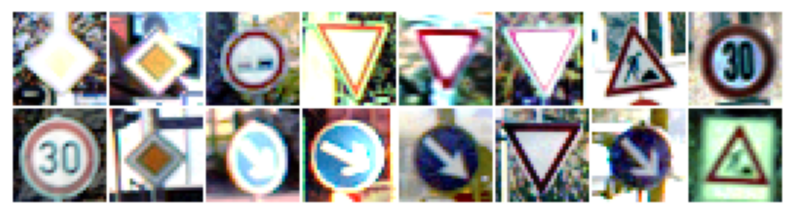

Reconstructed Images


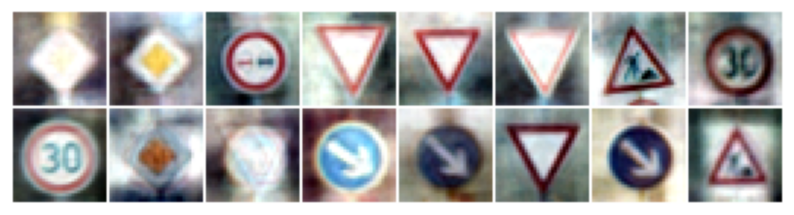

In [41]:
print("Original Images")
plot_images(denormalize(data[rnd_indices]))
print("Reconstructed Images")
plot_images(denormalize(torch.from_numpy(rec[rnd_indices])))

# Summary

In [42]:
print("KMeans-Images - Clustering Result")
evaluate_clustering(labels, kmeans_images.labels_)
print("\nKMeans - Clustering Result")
evaluate_clustering(labels, kmeans.labels_)
print("\nDCN - Clustering Result")
evaluate_clustering(labels, dcn.labels_)
print("\nDEC - Clustering Result")
evaluate_clustering(labels, dec.labels_)
print("\nIDEC - Clustering Result")
evaluate_clustering(labels, idec.labels_)
print("\nACeDeC - Clustering Result")
evaluate_clustering(labels, acedec.labels_)

KMeans-Images - Clustering Result
ACC: 32.69, ARI: 10.62, NMI: 15.58, AMI: 15.52

KMeans - Clustering Result
ACC: 71.69, ARI: 51.62, NMI: 59.13, AMI: 59.10

DCN - Clustering Result
ACC: 73.43, ARI: 63.07, NMI: 69.39, AMI: 69.37

DEC - Clustering Result
ACC: 69.36, ARI: 59.96, NMI: 68.17, AMI: 68.15

IDEC - Clustering Result
ACC: 78.70, ARI: 66.47, NMI: 70.68, AMI: 70.67

ACeDeC - Clustering Result
ACC: 75.92, ARI: 59.79, NMI: 66.51, AMI: 66.49


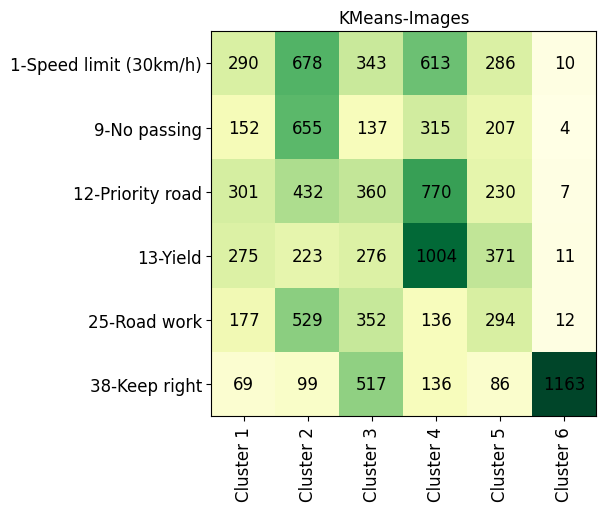

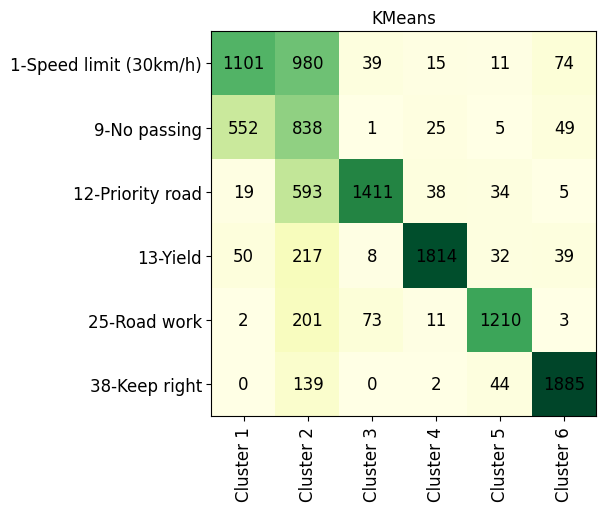

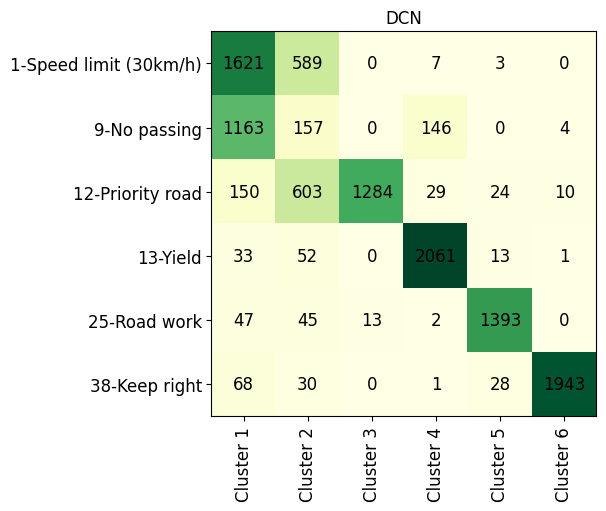

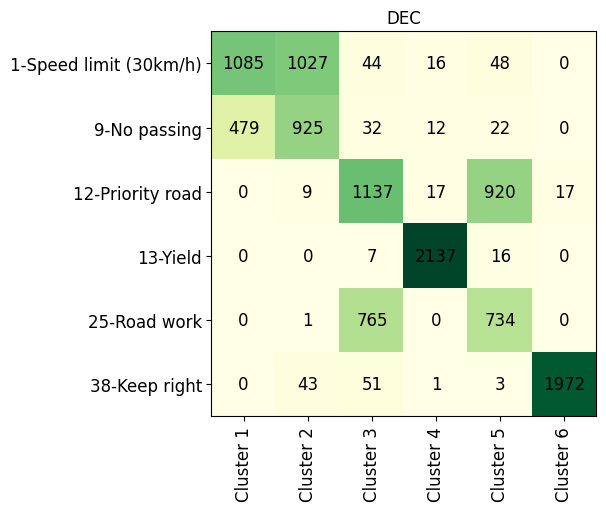

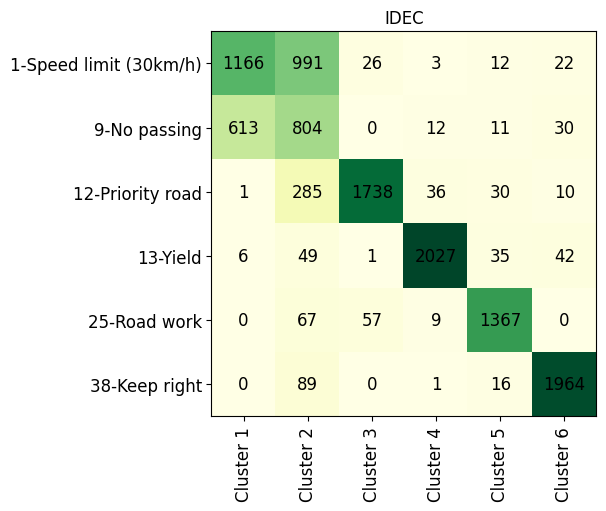

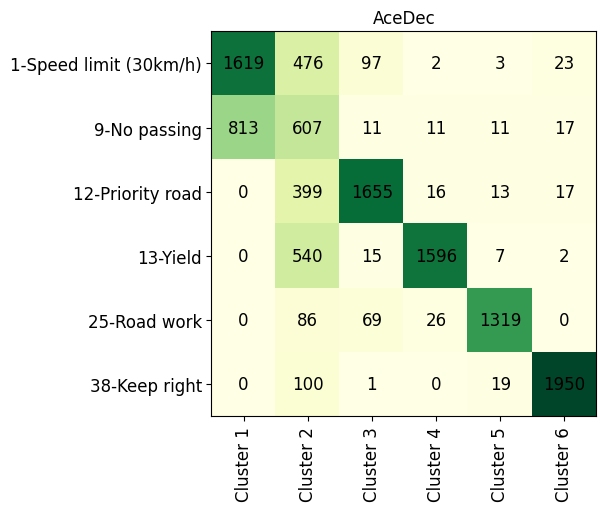

In [43]:
plot_confusion_matrix(labels, kmeans_images.labels_, label_names=label_names, title="KMeans-Images")
plot_confusion_matrix(labels, kmeans.labels_, label_names=label_names, title="KMeans")
plot_confusion_matrix(labels, dcn.labels_, label_names=label_names, title="DCN")
plot_confusion_matrix(labels, dec.labels_, label_names=label_names, title="DEC")
plot_confusion_matrix(labels, idec.labels_, label_names=label_names, title="IDEC")
plot_confusion_matrix(labels, acedec.labels_, label_names=label_names, title="AceDec")